In [67]:
#!g1.1
%pip install -r requirements.txt
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import optuna
from optuna.trial import TrialState

import numpy as np
import pandas as pd

import random as rnd
import os
import math
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
from cairosvg import svg2png
from IPython import display

import utils.dataloader as dl
from utils.svg import SVG
import umap

%matplotlib inline

In [2]:
#!g1.4
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 80
# fonts_number = 100
# fonts_number = 8000
fonts_number = None

print(f'Device: {device}')

Device: cuda


## Загрузка данных

In [3]:
stored_path = Path(f'data/data_abs_{SVG.ENCODE_HEIGHT}_{fonts_number}.json')
if stored_path.exists():
    print("Loading from file")
    data = pd.read_json(str(stored_path))
else:
    print('Loading data')
    dl.load_data(fonts_number)
    print('Encoding data')
    data = dl.get_data(fonts_number)
    data.to_json(str(stored_path))
print("Success")
data

Loading from file
Success


,font,letter,data
0,!crass_roots_ofl,a,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,!crass_roots_ofl,b,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,!crass_roots_ofl,c,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,!crass_roots_ofl,d,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,!crass_roots_ofl,e,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
337502,çarsi,v,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
337503,çarsi,w,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
337504,çarsi,x,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
337505,çarsi,y,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Определение даталоадеров
`Dataloader` для букв

In [4]:
class Dataloader:
    def __init__(self, df: pd.DataFrame, test_size=0.1, shuffle=False, batch_size=24):
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        xs = np.array(df['data'].to_list(), dtype=np.float32)
        ys = df['letter'].to_numpy()
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(xs, ys, test_size=test_size, shuffle=shuffle)
        self.batch_size = batch_size

    def iterate(self):
        bs = self.batch_size
        for i in range(len(self.x_train) // bs):
            yield self.x_train[i * bs: (i + 1) * bs], self.y_train[i * bs: (i + 1) * bs]

    def iterate_test(self):
        yield self.x_test, self.y_test

    def __len__(self):
        return len(self.x_train) // self.batch_size + int(len(self.x_train) % self.batch_size > 0)

dataloader = Dataloader(data, test_size=0.15, shuffle=True)

In [5]:
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

def show_sampled(x: np.ndarray):
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    plt.imshow(img)

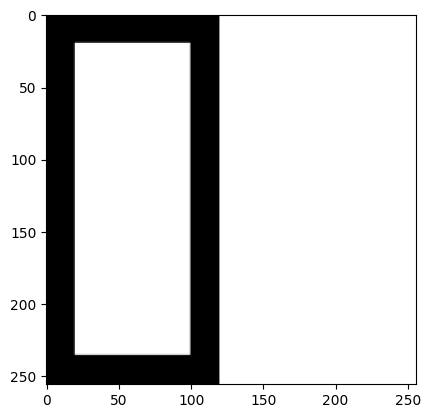

In [6]:
save_sampled(dataloader.x_test[1], 'test_print.svg')
show_sampled(dataloader.x_test[1])

## Определение рисователя прогресса

In [7]:
from typing import Optional

In [8]:
class Progresser:
    def __init__(self, split_num=4):
        self.epoch = 0
        self.train_ts, self.train_loss = [], []
        self.test_ts, self.test_loss = [], []
        self.interval = len(dataloader) // split_num

    def show_progress(self, t, epochs, save_to=None, info: Optional[dict] = None):
        display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
        fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)

        last_size = 0.5

        for ax, msg in zip((ax1, ax2), ('', f'last {int(last_size*100)}%')):
            title = f'loss {msg}'
            if info is not None:
                title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
            ax.set_title(title)
            ax.set_xlabel('time (epochs)')
            ax.set_ylabel('loss')
        last_train = str(self.train_loss[-1]) if len(self.train_loss) > 0 else ''
        last_test = str(self.test_loss[-1]) if len(self.test_loss) > 0 else ''

        ax1.plot(self.train_ts, self.train_loss, c='darkblue', lw=3, label=f'train: {last_train}')
        ax1.plot(self.test_ts, self.test_loss, c='green', marker='o', lw=5, label=f'test: {last_test}')

        ax2.plot(
            self.train_ts[-int(len(self.train_ts)*last_size):], 
            self.train_loss[-int(len(self.train_loss)*last_size):], 
            c='darkblue', lw=3, label=f'train: {last_train}',
        )
        ax2.plot(
            self.test_ts[-int(len(self.test_ts)*last_size):], 
            self.test_loss[-int(len(self.test_loss)*last_size):], 
            c='green', marker='o', lw=5, label=f'test: {last_test}'
        )

        ax1.legend()
        ax2.legend()
        if save_to is None:
            plt.show() 
        else:
            plt.savefig(save_to)
            plt.show()
            plt.close()
    
    def add_train(self, ts, loss):
        self.train_ts.append(ts)
        self.train_loss.append(loss)

    def add_test(self, ts, loss):
        self.test_ts.append(ts)
        self.test_loss.append(loss)
        
    def reset(self):
        self.train_ts = []
        self.test_ts = []
        self.train_loss = []
        self.test_loss = []
        self.epoch = 0


progresser = Progresser()

## Определение моделей

### Вспомогательные модули

In [9]:
class BnAndDropout(nn.Module):
    def __init__(self, features, p=0.15):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features=features)
        self.do = nn.Dropout(p)
    
    def forward(self, x):
        return self.do(self.bn(x))


class Block(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.Tanh(),
            # BnAndDropout(f_out),
        )

    def forward(self, x):
        return self.layer(x)


class TimeBlock(nn.Module):
    def __init__(self, f_in, f_out, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        self.layer = nn.Sequential(
            nn.Linear(f_in + time_emb_dim, f_out),
            nn.Tanh(),
            # BnAndDropout(f_out),
        )

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = torch.cat((x, t), dim=1)
        return self.layer(x)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


### Простой автоэнкодер для строк **(НЕ ИСПОЛЬЗУЕТСЯ)**

In [10]:
class AE(nn.Module):
    def __init__(self, params):
        super().__init__()
        
        self.encode = True
        self.decode = True
        
        self.inp_size = params[0]
        self.out_size = params[-1]

        self.encoder = []
        for i in range(len(params) - 1):
            self.encoder.append(Block(params[i], params[i + 1]))
        
        self.decoder = []
        for i in range(len(params) - 1, 0, -1):
            self.decoder.append(Block(params[i], params[i - 1]))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def forward(self, x):
        if self.encode:
            x = self.encoder(x)
        if self.decode:
            x = self.decoder(x)
        return x

    def loss(self):
        def _inner(y_hat, y):
            return ((y - y_hat)**2).mean(axis=0).sum()

        return _inner

    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, inp_data in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)

            output = self(inp_data)
            loss = loss_fn(output, inp_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.eval()
        num_batches = len(dataloader)
        tmp_test_loss = []
        for images in dataloader.iterate_test():
            images = torch.Tensor(images).to(device)

            decoded = self(images)
            loss = loss_fn(decoded, images)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)

### Автоэнкодер с условием
и кодированием каждой линии предыдущей моделью

In [10]:
class CAE(nn.Module):
    def __init__(self, params, in_labels, line_size):
        super().__init__()
        self.line_size = line_size
        
        self.encode = True
        self.decode = True
        
        encoder_params = params[:]
        encoder_params[0] += in_labels
        
        decoder_params = params[::-1]
        decoder_params[0] += in_labels

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(Block(encoder_params[i], encoder_params[i + 1]))

        self.decoder = []
        for i in range(len(decoder_params) - 1):
            self.decoder.append(Block(decoder_params[i], decoder_params[i + 1]))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def forward(self, x, labels):
        bs = x.shape[0]
        if self.encode:
            x = x.view(bs, -1)
            x = torch.cat((x, labels), 1)
            x = self.encoder(x)
        if self.decode:
            x = torch.cat((x, labels), 1)
            x = self.decoder(x)
            x = x.view(bs, -1, self.line_size)
        return x
    
    def loss(self):
        def _inner(y_hat, y):
            return ((y - y_hat)**2).mean(axis=0).sum()

        return _inner
    
    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (inp_data, labels) in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)

            output = self(inp_data, labels)
            loss = loss_fn(output, inp_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.eval()
        tmp_test_loss = []
        for inp_data, labels in dataloader.iterate_test():
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)

            result = self(inp_data, labels)
            loss = loss_fn(result, inp_data)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)

## Автоэнкодер с условием и skip connection
Ядро дифузионной модели. 

U - UNET-like\
С - conditional\
A - auto\
E - encoder

In [11]:
class UCAE(nn.Module):
    def __init__(self, params, in_labels, time_emb_dim=32):
        super().__init__()
        
        encoder_params = params[:]
        encoder_params[0] += in_labels
        
        decoder_params = params[::-1]
        decoder_params[0] += in_labels

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(TimeBlock(encoder_params[i], encoder_params[i + 1], time_emb_dim))

        self.decoder = []
        self.decoder.append(TimeBlock(decoder_params[0], decoder_params[1], time_emb_dim))
        for i in range(1, len(decoder_params) - 1):
            self.decoder.append(TimeBlock(decoder_params[i] * 2, decoder_params[i + 1], time_emb_dim))
        
        self.encoder = nn.ModuleList(self.encoder)
        self.decoder = nn.ModuleList(self.decoder)
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        
    def forward(self, x, labels, timestep):
        shape = x.shape
        t = self.time_mlp(timestep)
        x = torch.cat((x, labels), 1)
        accumulate = []
        for layer in self.encoder:
            x = layer(x, t)
            accumulate.append(x)
        accumulate.pop()
        
        x = torch.cat((x, labels), 1)
        x = self.decoder[0](x, t)
        
        for layer in self.decoder[1:]:
            connection = accumulate.pop()
            x = torch.cat((x, connection), 1)
            x = layer(x, t)
        return x
    
    def loss(self):
        def _inner(y_hat, y):
            return ((y - y_hat)**2).mean(axis=0).sum()

        return _inner
    
    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (inp_data, labels) in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.zeros([len(labels)]).to(device)

            output = self(inp_data, labels, t)
            loss = loss_fn(output, inp_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.eval()
        tmp_test_loss = []
        for inp_data, labels in dataloader.iterate_test():
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.zeros([len(labels)], dtype=torch.int64).to(device)

            result = self(inp_data, labels, t)
            loss = loss_fn(result, inp_data)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progreser.show_progress(epoch, epochs)

## Вспомогательные функции

In [12]:
ONE_HOT_LEN = len(dl.GLYPH_FILTER)
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER, 
        range(0, ONE_HOT_LEN),
    )
}

def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()

def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)

In [13]:
def run(model, dataloader, optimizer, scheduler, epochs, params, batch_size, _epoch=0, run_name=None, trial=None, save=True):
    class_name = model.__class__.__name__
    if run_name is None:
        run_name = f'{class_name}_{SVG.ENCODE_HEIGHT}_{",".join(map(str, params))}'

    save_folder = Path('models') / class_name / run_name
    loss_img_path = str(save_folder / '_loss.png') if save else None
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    file_format = 'svg'
    max_epoch = progresser.epoch + epochs
    loss_fn = model.loss()
    dataloader.batch_size = batch_size

    if trial is None:
        pbar = trange(progresser.epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(progresser.epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, dataloader, loss_fn, optimizer, scheduler, pbar, show=True)
        model.test_fn(_epoch + 1, max_epoch, dataloader, loss_fn, show=True)

        if save:
            torch.save(model.state_dict(), save_folder / 'ckpt.pt')

        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            progresser.epoch = _epoch + 1
        progresser.show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})
    

In [14]:
def setup_maker(model_type):
    def _inner(params, lr, weight_decay=2e-5, step_size=1, step_gamma=0.95, line_size=None):
        if model_type == 'cae':
            if line_size is None:
                raise Exception('line_size should be provided')
            model = CAE(params, ONE_HOT_LEN, line_size).to(device)
        elif model_type == 'ucae':
            model = UCAE(params, ONE_HOT_LEN).to(device)
        elif model_type == 'ae':
            model = AE(params).to(device)
        else:
            raise Exception('Unexpected model type')

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)

        progresser.reset()

        return model, optimizer, scheduler

    return _inner
    
setup_ae = setup_maker('ae')
setup_cae = setup_maker('cae')
setup_ucae = setup_maker('ucae')

## Поиск конфигурации модели для кодирования глифов

Запуск дашборда `optuna-dashboard --server wsgiref sqlite:///db.sqlite3`
http://127.0.0.1:8080/

In [ ]:
#!g1.4
def run_for_search(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    p0 = trial.suggest_int('p0', 2000, 4000)
    p1 = trial.suggest_int('p0', 1800, 3600)
    params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, p0, p1]
    latent_size = trial.suggest_int('z', 300, 1200)
    
    for i in range(2, 6):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    step_gamma = trial.suggest_float('step_gamma', 0.94, 1)
    
    model, optimizer, scheduler = setup_cae(
        params=params,
        lr=lr,
        weight_decay=6e-6,
        line_size=SVG.ENCODE_WIDTH,
        step_gamma=step_gamma,
    )
    run(
        model=model, 
        dataloader=dataloader, 
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=15,
        params=params,
        batch_size=100,
        run_name='temp',
        trial=trial,
    )
    return progresser.test_loss[-1]


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db.sqlite3",
    study_name="cae_tanh_abs_search_lr,step,7layers,15epoch",
    load_if_exists=True,
)

study.optimize(run_for_search, n_trials=7, show_progress_bar=True)

In [16]:
#!g1.4
GLIPH_WIDTH = 400
params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 3900, 3800, 3700, 2900, 1800, GLIPH_WIDTH]

# lr = 1e-4
lr = 2.8e-7

model_cae_path = f'models/CAE/CAE_{SVG.ENCODE_HEIGHT}_{",".join(map(str,params))}/ckpt.pt'
model_cae, optimizer, scheduler = setup_cae(
    params=params,
    lr=lr,
    weight_decay=6e-6,
    line_size=SVG.ENCODE_WIDTH,
    step_size=3,
    step_gamma=0.968,
)
if Path(model_cae_path).exists():
    print('Loaded from file')
    model_cae.load_state_dict(torch.load(model_cae_path))
else:
    print('Created new')

Loaded from file


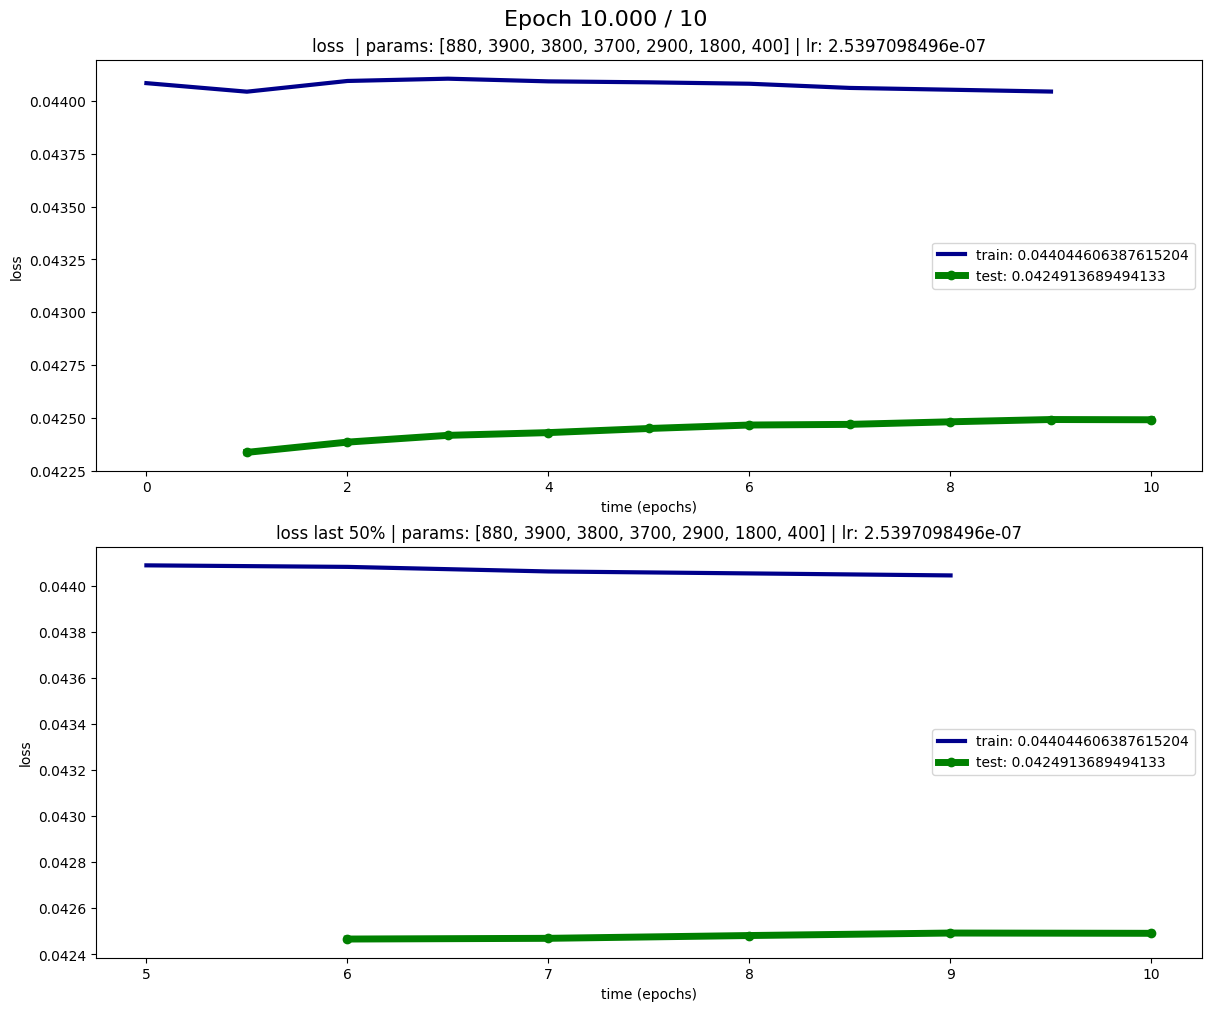

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:52<00:00, 53.21s/it]


In [17]:
#!g1.4
run(
    model=model_cae,
    dataloader=dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    params=params,
    batch_size=256,
)

['p' 'j' 'w' 'b' 'h' 's']


C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_15276\3153489897.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, imgs_num, i + 1)


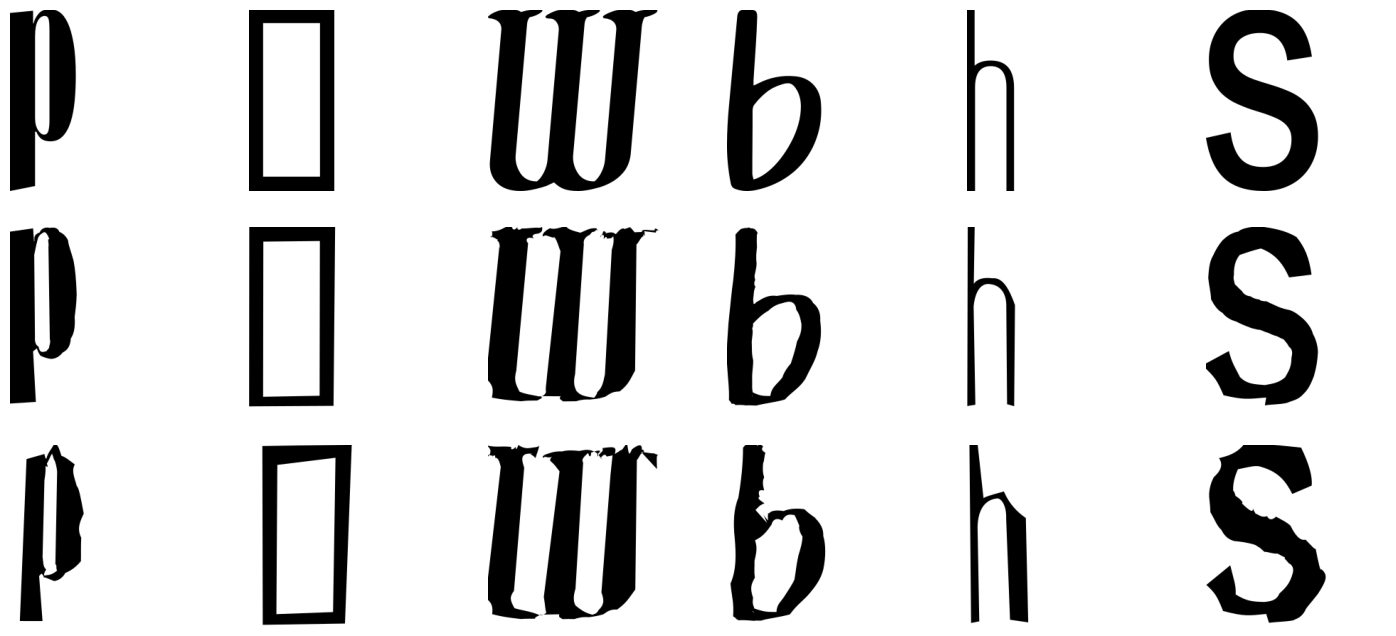

In [18]:
imgs_num = 6
plt.figure(figsize=(3 * imgs_num, 8))
plt.axis('off')

model_cae.encode = True
model_cae.decode = True
    
samples = dataloader.x_test[:imgs_num]
labels = dataloader.y_test[:imgs_num]
print(labels)
labels = labels2one_hot(labels).to(device)
model_cae.eval()
processed_samples = model_cae(torch.Tensor(samples).to(device), labels).cpu().detach().numpy()

a_labels = ['a'] * imgs_num
a_labels = labels2one_hot(a_labels).to(device)
model_cae.decode = False
a_samples = model_cae(torch.Tensor(samples).to(device), labels)
model_cae.decode = True
model_cae.encode = False
a_samples = model_cae(a_samples, a_labels).cpu().detach().numpy()
model_cae.encode = True

for i in range(imgs_num):
    plt.subplot(3, imgs_num, i + 1)
    plt.axis('off')
    show_sampled(samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num + i + 1)
    plt.axis('off')
    show_sampled(processed_samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, 2 * imgs_num + i + 1)
    plt.axis('off')
    show_sampled(a_samples[i])
plt.show()

In [29]:
def decode_img(d, label):
    model_cae.decode = True
    model_cae.encode = False
    model_cae.eval()
    single = False
    if isinstance(label, str):
        single = True
        d = torch.Tensor([d]).to(device)
        label = labels2one_hot([label]).to(device)
    with torch.no_grad():
        origin = model_cae(d, label)
        model_cae.encode = True
        if single:
            return origin[0]
        return origin

def encode_img(d, label):
    model_cae.decode = False
    model_cae.encode = True
    model_cae.eval()
    single = False
    if isinstance(label, str):
        single = True
        label = labels2one_hot([label]).to(device)
        d = torch.Tensor([d]).to(device)

    with torch.no_grad():
        image = model_cae(d, label)
        model_cae.decode = True
        if single:
            return image[0]
        return image

def to_numpy(d):
    return d.cpu().detach().numpy()

## UMAP проверка

#### Проверяю по лейблам

In [73]:
encoded_data = []
y_data = []
# there are too many images to do it by one execution
for inp_data, labels in dataloader.iterate():
    inp_data = torch.Tensor(inp_data).to(device)
    y_data.append(labels)
    labels = labels2one_hot(labels).to(device)

    encoded_batch = encode_img(inp_data, labels)
    encoded_data.append(encoded_batch)

y_data = np.concatenate(y_data, axis=0)
encoded_data = to_numpy(torch.cat(encoded_data, 0))
print("Data shape", encoded_data.shape)
umap_model = umap.UMAP(n_neighbors=12)
embedding = umap_model.fit_transform(encoded_data)

del encoded_data

Data shape (286720, 400)


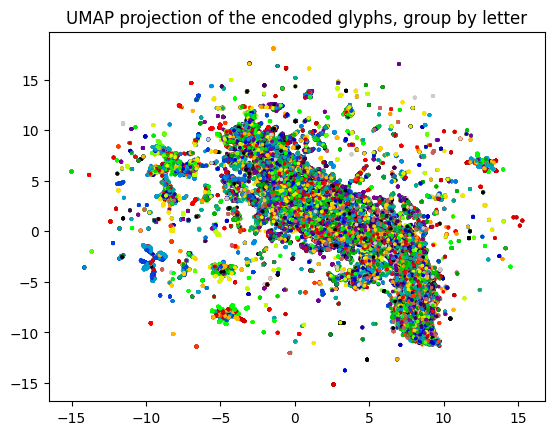

In [74]:
plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=to_numpy(labels2num(y_data)), 
    cmap='nipy_spectral', s=3
)
plt.title('UMAP projection of the encoded glyphs, groupped by letter');
plt.show()

#### Проверяю нa схожесть букв в одном шрифте

In [85]:
data_with_fonts = data.iloc[:512]
x_data = np.array(data_with_fonts['data'].to_list(), dtype=np.float32)
x_data = torch.Tensor(x_data).to(device)
y_data = data_with_fonts['letter'].to_numpy()
font_names = data_with_fonts['font'].to_numpy()

x_data = torch.Tensor(x_data).to(device)
y_data = labels2one_hot(y_data).to(device)

encoded_data = to_numpy(encode_img(x_data, y_data))

embedding_fonts = umap_model.fit_transform(encoded_data)
del encoded_data

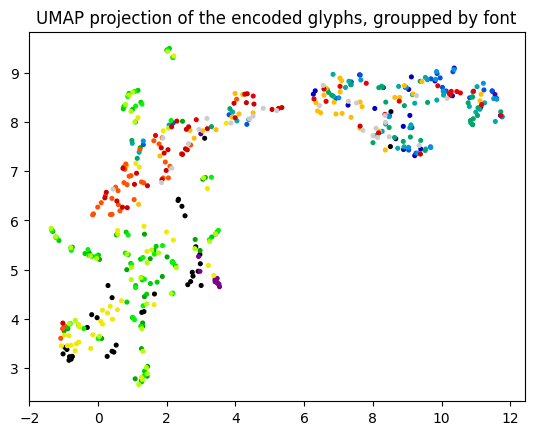

In [87]:
unique_fonts = np.unique(font_names).tolist()
colors = [unique_fonts.index(i) for i in font_names]

plt.scatter(
    embedding_fonts[:, 0], embedding_fonts[:, 1], 
    c=colors, 
    cmap='nipy_spectral', s=7
)
plt.title('UMAP projection of the encoded glyphs, groupped by font');
plt.show()

## Дифузионная модель

In [27]:
#!g1.4
class Diffusion:
    def __init__(self, model_inner, model_encoder):
        self.T = 300
        self.betas = self.linear_beta_schedule(timesteps=self.T)

        # Pre-calculate different terms for closed form
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
        self.model = model_inner
        self.model_encoder = model_encoder
        self.model_encoder.eval()
    
    @staticmethod
    def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
        return torch.linspace(start, end, timesteps)

    @staticmethod
    def get_index_from_list(vals, t, x_shape):
        """ 
        Returns a specific index t of a passed list of values vals
        while considering the batch dimension.
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward_diffusion_sample(self, x_0, t):
        """ 
        Takes an image and a timestep as input and 
        returns the noisy version of it
        """
        noise = torch.randn_like(x_0).to(device)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def get_loss(self, x_0, labels, t):
        x_noisy, noise = self.forward_diffusion_sample(x_0, t)
        noise_pred = self.model(x_noisy, labels, t)
        return F.l1_loss(noise, noise_pred)

    @torch.no_grad()
    def sample_timestep(self, x, labels, t):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        sqrt_recip_alphas_t = self.get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # Call model (current image - noise prediction)
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.model(x, labels, t) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = self.get_index_from_list(self.posterior_variance, t, x.shape)

        if t == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise 

    @torch.no_grad()
    def sample_plot_image(self):
        # Sample noise
        img = torch.randn((1, GLIPH_WIDTH), device=device)
        label_ind = rnd.randrange(ONE_HOT_LEN)
        label = torch.zeros((1, ONE_HOT_LEN), dtype=torch.float32, device=device)
        label[0, label_ind] = 1
        plt.figure(figsize=(15,15))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T / num_images)

        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.int64)
            img = self.sample_timestep(img, label, t)
            if i % stepsize == 0:
                plt.subplot(1, num_images, i // stepsize + 1)
                show_sampled(to_numpy(decode_img(img, label)))
        plt.show()
    
    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.model.train()
        num_batches = len(dataloader)
        for batch, (inp_data, labels) in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            
            self.model_encoder.encode = True
            self.model_encoder.decode = False
            
            with torch.no_grad():
                inp_data = self.model_encoder(inp_data, labels)
            
            t = torch.randint(0, self.T, [len(labels)], device=device).long()
            
            optimizer.zero_grad()

            loss = self.get_loss(inp_data, labels, t)
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.model.eval()
        tmp_test_loss = []
        for inp_data, labels in dataloader.iterate_test():
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            
            self.model_encoder.encode = True
            self.model_encoder.decode = False
            inp_data = self.model_encoder(inp_data, labels)
            
            t = torch.randint(0, self.T, [len(labels)], device=device).long()
            
            loss = self.get_loss(inp_data, labels, t)
            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            # show_progress(epoch, epochs)
            self.sample_plot_image()
            
    def loss(self):
        return None
    
    def state_dict(self):
        return self.model.state_dict()

k


C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_15888\834775181.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, (idx // stepsize) + 1)


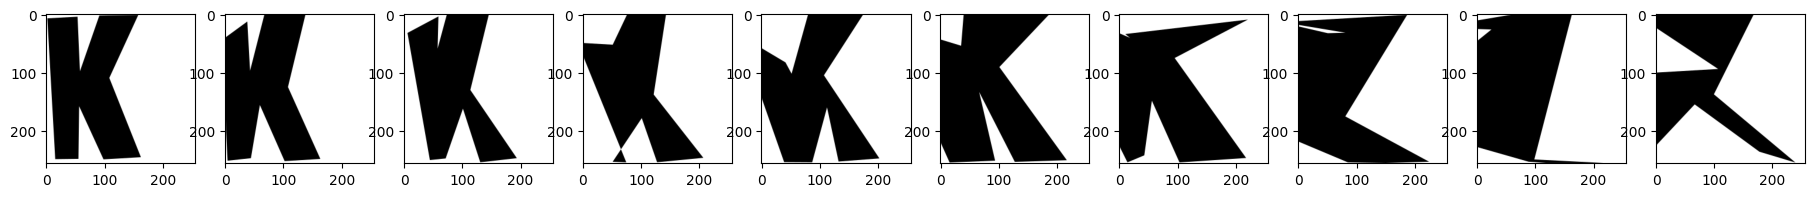

In [28]:
#!g1.4
diffusion = Diffusion(None, model_cae)

image = dataloader.x_test[1]
label = dataloader.y_test[1]
print(label)
image = encode_img(image, label)

plt.figure(figsize=(25, 20))
plt.axis('off')
num_images = 10

# stepsize = diffusion.T // num_images
stepsize = 1

# for idx in range(0, diffusion.T, stepsize):
for idx in range(0, 10):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    plt.subplot(1, num_images + 1, (idx // stepsize) + 1)
    image, noise = diffusion.forward_diffusion_sample(image, t)
    decoded_svg = to_numpy(decode_img(to_numpy(image), label))
    show_sampled(decoded_svg)

In [29]:
#!g1.4
params = [GLIPH_WIDTH, 2350, 1800, 1640, 1128, 500]


model_d, optimizer, scheduler = setup_ucae(
    params=params,
    lr=2e-4,
    weight_decay=2e-5,
    step_size=3,
)

diffusion = Diffusion(model_d, model_cae)

print("Num params: ", sum(p.numel() for p in model_d.parameters()))

Num params:  31666872


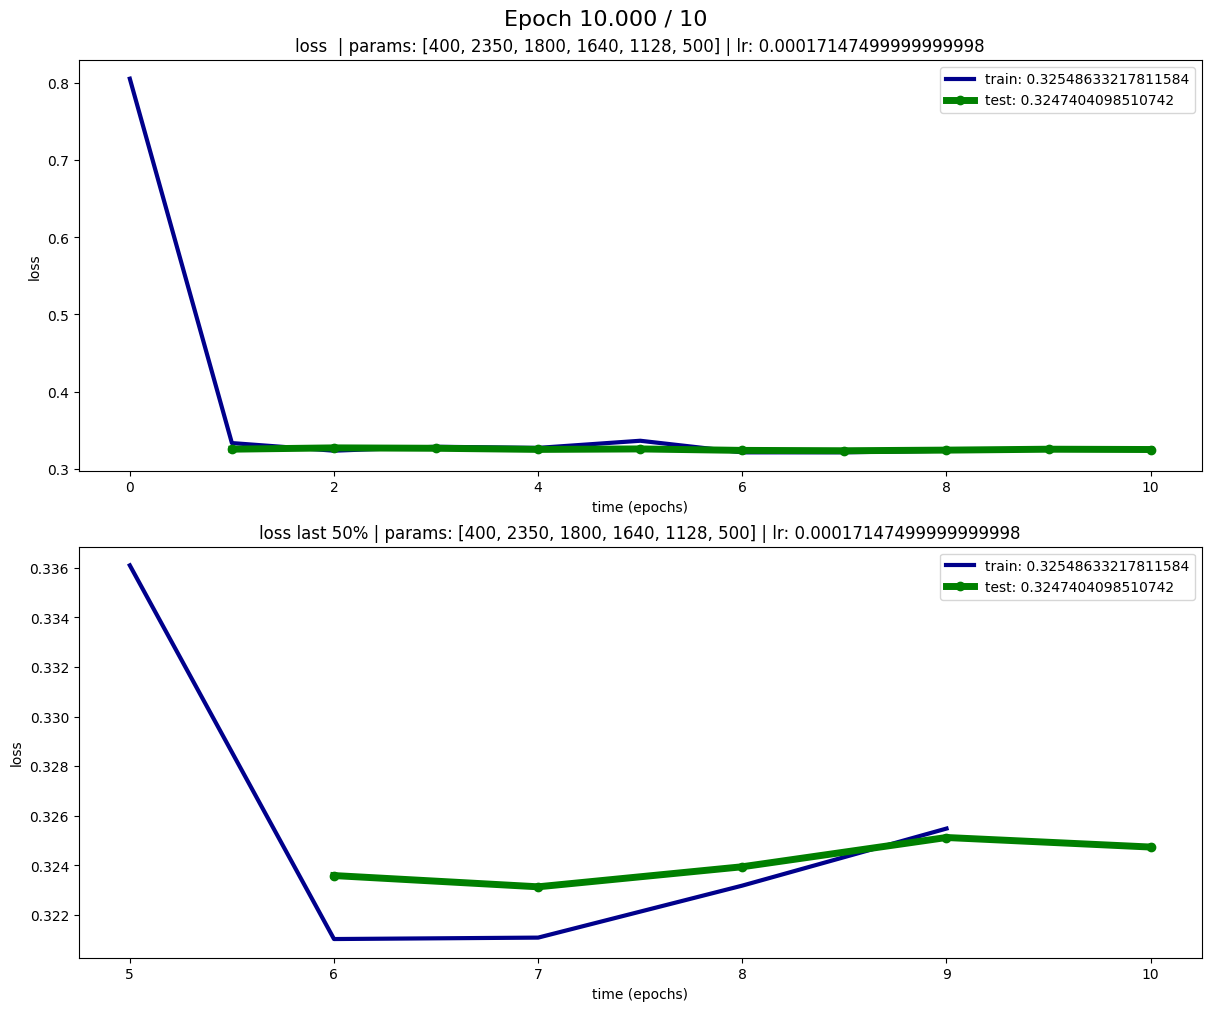

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:25<00:00, 44.50s/it]


In [30]:
#!g1.4
run(
    model=diffusion, 
    dataloader=dataloader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=10,
    params=params,
    batch_size=128,
)

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_15888\1320661319.py:93: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i // stepsize + 1)


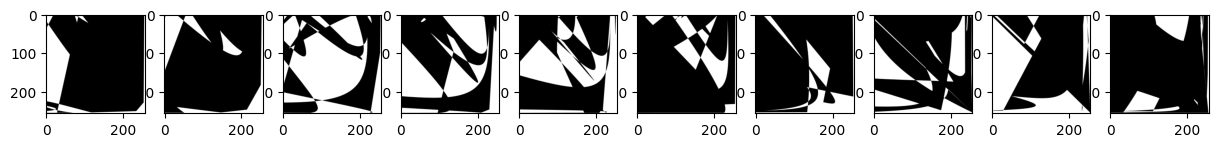

In [31]:
#!g1.4
diffusion.sample_plot_image()